In [1]:
from cProfile import label
from email import header
from ntpath import join
from os import sep
from statistics import mean, median
from tkinter.ttk import Separator
from xml.etree.ElementPath import xpath_tokenizer
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
import numpy as np
import seaborn as sns
from scipy.signal import find_peaks
import pingouin as pg
from pingouin import homoscedasticity

In [2]:
#data, we would like to evaluate and source (python/kinect)
healthy='ZM001_b_data_new'
paralyzed='SM003_bal_data_new'
source='kinect'

if source=='kinect':
    #load data for healthy one kinect
    datah=pd.read_csv(join(r'C:\Users\kuba8\MATLAB Drive\projekt oblicej\dataPython',healthy+'.txt'),sep=' ',header=None)
    datah=datah.transpose()

    #load data for paralyzed one kinect
    datap=pd.read_csv(join(r'C:\Users\kuba8\MATLAB Drive\projekt oblicej\dataPython',paralyzed+'.txt'),sep=' ',header=None)
    datap=datap.transpose()

elif source=='python':
    # for python
    #load data for healthy one
    datah=pd.read_csv(join(r'C:\Users\kuba8\Desktop\studium\Python_record\python_data',healthy+'.txt'),sep=' ',header=None)
    datah=datah.transpose()

    #load data for paralyzed one
    datap=pd.read_csv(join(r'C:\Users\kuba8\Desktop\studium\Python_record\python_data',paralyzed+'.txt'),sep=' ',header=None)
    datap=datap.transpose()

C:\Users\kuba8\miniconda3\envs\julab\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


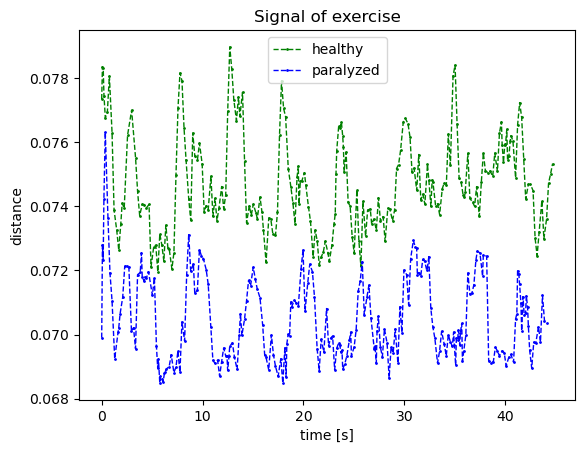

In [3]:
#number of the study point
num=2

#plot measured line
f,ax = plt.subplots()
plt.plot(datah[len(datah.columns)-1]-datah[len(datah.columns)-1][0],datah[num], color='green', linestyle='dashed', linewidth = 1, marker='o', markerfacecolor='green', markersize=1,label='healthy')
plt.plot(datap[len(datah.columns)-1]-datap[len(datah.columns)-1][0],datap[num], color='blue', linestyle='dashed', linewidth = 1, marker='o', markerfacecolor='blue', markersize=1,label='paralyzed')
ax.set_title('Signal of exercise')
ax.set_xlabel('time [s]')
ax.legend()
if num<0:
    ax.set_ylabel('angle [degrees]')
else:
    ax.set_ylabel('distance')
plt.show()

In [4]:
#fuction for selecting specific area 
def select2(x,rel_hig, wid,dis,a,b,promin=0):

    #set initial prominence
    if promin==0:
        promin=(max(x[a:b])-mean(x[a:b]))*0.5

    #function for finding peaks
    peaks, properties = find_peaks(x[a:b], prominence=promin, rel_height=rel_hig, width=wid, distance=dis)

    #repeat until number of pekas is less or equal than 6
    if len(peaks)>6:
        promin=promin+0.002
        peaks,properties=select2(x, rel_hig, wid,dis,a,b,promin)
    properties["prominences"], properties["widths"]

    #returns oder indexes of peaks(peaks) and borders of peaks(properties)
    return peaks, properties

In [5]:
#function for making signal wthout noise
def selectpeaks(xv,yv,p, rel_hig, wid,dis,a=0,b=0):
    if b==0:
        b=len(yv)

    #get information about specific area
    peak,prop=select2(yv, rel_hig, wid,dis,a,b)
    peak=peak+a

    #plot selected peaks
    plt.plot(yv)
    plt.plot(peak, yv[peak], "x")
    plt.vlines(x=peak, ymin=yv[peak] - prop["prominences"], ymax = yv[peak], color = "C1")
    plt.hlines(y=prop["width_heights"], xmin=prop["left_ips"]+a, xmax=prop["right_ips"]+a, color = "C1")
    plt.show()

    #make from peaks one signal with x and y coordinates
    x=np.array([])
    y=np.array([])
    for i in range(0,len(peak)):
        xpo=xv[round(prop['left_ips'][i]+a)-p:round(prop['right_ips'][i]+a)+p]
        ypo=yv[round(prop['left_ips'][i]+a)-p:round(prop['right_ips'][i]+a)+p]
        x=np.append(x,xpo)
        y=np.append(y,ypo)
    return x,y

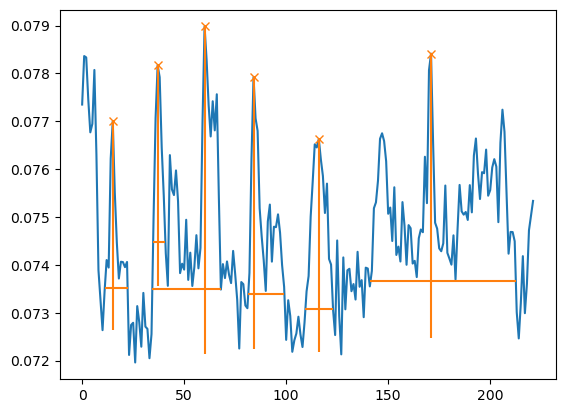

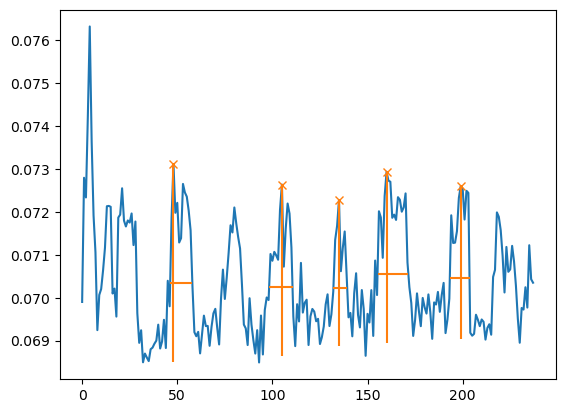

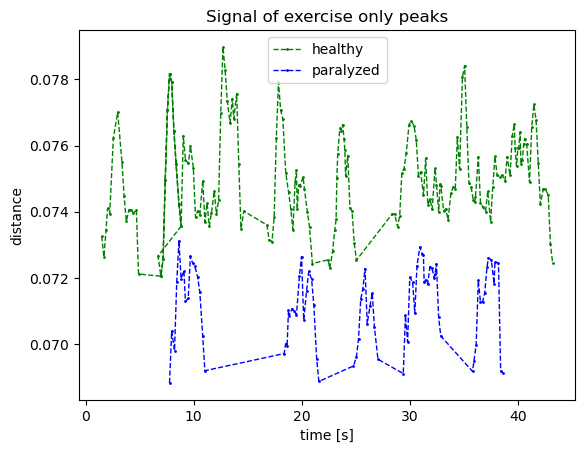

In [6]:
#get signal with exercises from two signals
xh,yh=selectpeaks(datah[len(datah.columns)-1]-datah[len(datah.columns)-1][0],datah[num],2,0.8,1,5.5)
xp,yp=selectpeaks(datap[len(datah.columns)-1]-datap[len(datah.columns)-1][0],datap[num],2,0.6,2,7.5,30)

#plot measured line only peaks
f,ax = plt.subplots()
plt.plot(xh, yh, color='green', linestyle='dashed', linewidth = 1, marker='o', markerfacecolor='green', markersize=1,label='healthy')
plt.plot(xp, yp, color='blue', linestyle='dashed', linewidth = 1, marker='o', markerfacecolor='blue', markersize=1,label='paralyzed')

ax.set_title('Signal of exercise only peaks')
ax.set_xlabel('time [s]')
ax.legend()

if num==0:
    ax.set_ylabel('angle [degrees]')
else:
    ax.set_ylabel('distance')
plt.show()

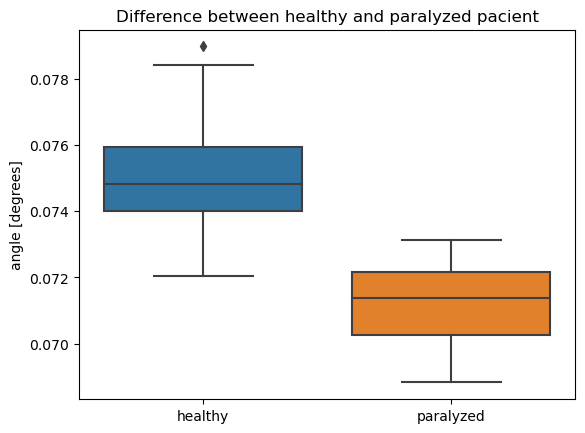

In [7]:
#boxplot
f,ax = plt.subplots()
ax.set_title('Difference between healthy and paralyzed pacient')
if num<12:
    ax.set_ylabel('angle [degrees]')
else:
    ax.set_ylabel('distance')
sns.boxplot([yh,yp])
ax.set(xticklabels=['healthy','paralyzed'])
plt.show()

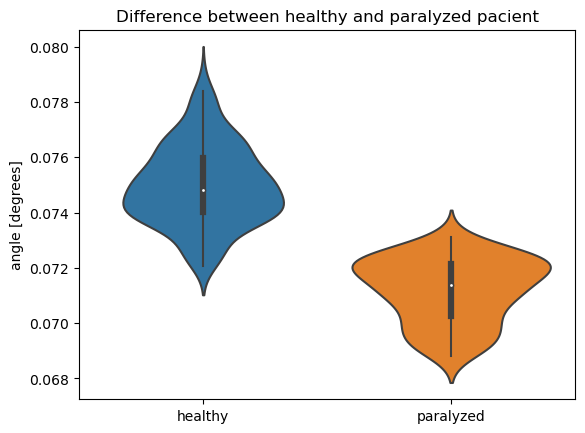

In [8]:
#violinplot
f,ax = plt.subplots()
ax.set_title('Difference between healthy and paralyzed pacient')
if num<12:
    ax.set_ylabel('angle [degrees]')
else:
    ax.set_ylabel('distance')

sns.violinplot([yh,yp])
ax.set_xticks([0,1])
ax.set(xticklabels=['healthy','paralyzed'])

plt.show()

In [9]:
def process(data,num,num2):

    #select specific points in signal
    peak1,prop1=select2(data[num],0.8,1,5.5,0,len(data))

    #widen area of peaks
    p=2
    x=np.array([])

    #make signal composed from exercises
    for j in range(len(peak1)):
        xpo=data[num2][round(prop1['left_ips'][j])-p:round(prop1['right_ips'][j])+p]
        x=np.append(x,xpo)
    return x

In [10]:
#make Kruskal-Will test for all records in names
index=np.array([])
p_val=pd.DataFrame([])
for l in range(0,17):
    dataset=pd.DataFrame([])   
    
    df1 = pd.DataFrame({'value':process(datah,2,l), 'label': 'healthy'})
    df2 = pd.DataFrame({'value':process(datap,1,l), 'label': 'paralyzed'})
    dataset=pd.concat([df1,df2], axis=0)
    
    if l<8:
        kr=pg.kruskal(dataset,dv='value',between='label')
        if kr['p-unc'][0]<0.05:
            hod=False
        else:
            hod=True
        kr=pd.DataFrame({'W':kr['H'],'pval':kr['p-unc'],'equal':hod})
    else:
        kr=homoscedasticity(dataset,dv='value',group='label')
        kr=pd.DataFrame({'W':kr['W'],'pval':kr['pval'],'equal':kr['equal_var']})
    #kr=kruskal(dataset.groupby(by='label'))
    p_val=pd.concat([p_val,kr])
    index=np.append(index,l)

p_val['point']=index

In [11]:
p_val

,W,pval,equal,point
Kruskal,159.886726,1.197836e-36,False,0.0
Kruskal,91.565299,1.079699e-21,False,1.0
Kruskal,179.364993,6.669134e-41,False,2.0
Kruskal,179.107639,7.590345e-41,False,3.0
Kruskal,182.078364,1.704681e-41,False,4.0
Kruskal,171.137473,4.175762e-39,False,5.0
Kruskal,112.474679,2.812338e-26,False,6.0
Kruskal,182.121598,1.668031e-41,False,7.0
levene,45.596257,8.771166e-11,False,8.0
levene,8.191363,4.536179e-03,False,9.0


In [12]:
pointsl = p_val[p_val["equal"] == False]

In [13]:
pointsl

,W,pval,equal,point
Kruskal,159.886726,1.197836e-36,False,0.0
Kruskal,91.565299,1.079699e-21,False,1.0
Kruskal,179.364993,6.669134e-41,False,2.0
Kruskal,179.107639,7.590345e-41,False,3.0
Kruskal,182.078364,1.704681e-41,False,4.0
Kruskal,171.137473,4.175762e-39,False,5.0
Kruskal,112.474679,2.812338e-26,False,6.0
Kruskal,182.121598,1.668031e-41,False,7.0
levene,45.596257,8.771166e-11,False,8.0
levene,8.191363,4.536179e-03,False,9.0


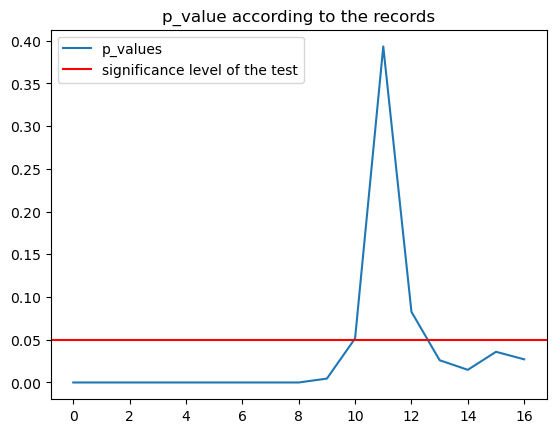

In [14]:
#plot p-values for each pair of value
plt.plot(p_val['point'],p_val['pval'],label='p_values')
plt.axhline(y=0.05, color='r', linestyle='-',label='significance level of the test')
plt.title('p_value according to the records')
plt.legend()
plt.show()

In [16]:
####################################################################### manual selecting
'''
#fuction for selecting specific area manually
def select(x,y):
    #select specific area from measured signal
    global peak
    peak=np.array([[0,0]])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot()

    ax.plot(x, y, '-')
    ax.set_title('Press left mouse button and drag to test')

    def onselect(xmin, xmax):
        global peak
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)

        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
    
        fig.canvas.draw_idle()

        peak=np.append(peak, np.c_[thisx, thisy],axis=0)
    
    # set useblit True on gtkagg for enhanced performance
    span = SpanSelector(ax, onselect, 'horizontal', useblit=True, rectprops=dict(alpha=0.5, facecolor='red'))
    plt.show()
    peak=peak.transpose()
    return peak

peakh=select(datah[40]-datah[40][0],datah[num])
peakp=select(datap[40]-datap[40][0],datap[num])

xh=peakh[0][1:len(peakh[0])]
yh=peakh[1][1:len(peakh[1])]
xp=peakp[0][1:len(peakp[0])]
yp=peakp[1][1:len(peakp[1])]
'''


"\n#fuction for selecting specific area manually\ndef select(x,y):\n    #select specific area from measured signal\n    global peak\n    peak=np.array([[0,0]])\n\n    fig = plt.figure(figsize=(8, 6))\n    ax = fig.add_subplot()\n\n    ax.plot(x, y, '-')\n    ax.set_title('Press left mouse button and drag to test')\n\n    def onselect(xmin, xmax):\n        global peak\n        indmin, indmax = np.searchsorted(x, (xmin, xmax))\n        indmax = min(len(x) - 1, indmax)\n\n        thisx = x[indmin:indmax]\n        thisy = y[indmin:indmax]\n    \n        fig.canvas.draw_idle()\n\n        peak=np.append(peak, np.c_[thisx, thisy],axis=0)\n    \n    # set useblit True on gtkagg for enhanced performance\n    span = SpanSelector(ax, onselect, 'horizontal', useblit=True, rectprops=dict(alpha=0.5, facecolor='red'))\n    plt.show()\n    peak=peak.transpose()\n    return peak\n\npeakh=select(datah[40]-datah[40][0],datah[num])\npeakp=select(datap[40]-datap[40][0],datap[num])\n\nxh=peakh[0][1:len(peak